In [3]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [8]:
dataset = pd.read_pickle("data/all_tickers_last_decade_features.pkl")

In [9]:
dataset.shape

(869435, 27)

### Tendencia
GGAL (USD) observa una tendencia que cambia de signo a partir de principios de 2018

In [10]:
ggal_5y = dataset.loc[(dataset.Year > 2015) & (dataset.Ticker == 'GGAL'),['Adj Close']]

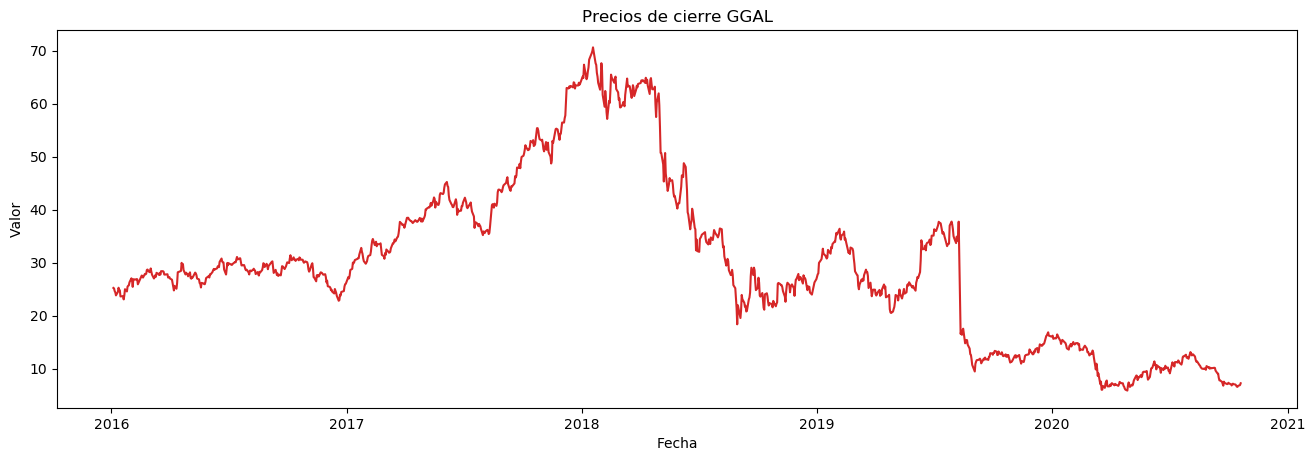

In [11]:
def plot_df(df, x, y, title="", xlabel='Fecha', ylabel='Valor', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(ggal_5y, x=ggal_5y.index, y=ggal_5y.loc[:,'Adj Close'], title='Precios de cierre GGAL')

### Estacionalidad
GGAL (USD) no presenta estacionalidad mensual

In [12]:
# Preparamos los datos:
ggal_5y['year'] = [d.year for d in ggal_5y.index]
ggal_5y['month'] = [d.strftime('%b') for d in ggal_5y.index]
years = ggal_5y['year'].unique()

In [13]:
# ¿Cuál es el último día registrado del mes?
ggal_5y.groupby(ggal_5y.index.to_period('M')).apply(lambda x: x.index.day.max()).head(12)

Date
2016-01    29
2016-02    29
2016-03    31
2016-04    29
2016-05    31
2016-06    30
2016-07    29
2016-08    31
2016-09    30
2016-10    31
2016-11    30
2016-12    30
Freq: M, dtype: int64

In [14]:
# Precio de cierre al ultimo día registrado del mes
ggal_last = ggal_5y.iloc[ggal_5y.reset_index().groupby(ggal_5y.index.to_period('M'))['Adj Close'].idxmax()]

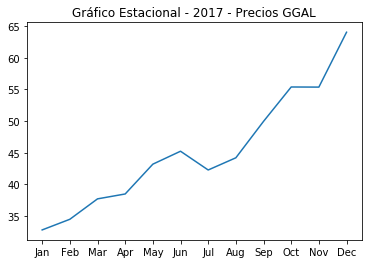

In [15]:
plt.plot('month', 'Adj Close', data=ggal_last.loc[ggal_last.year==2017, :])
plt.title("Gráfico Estacional - 2017 - Precios GGAL");
plt.show()

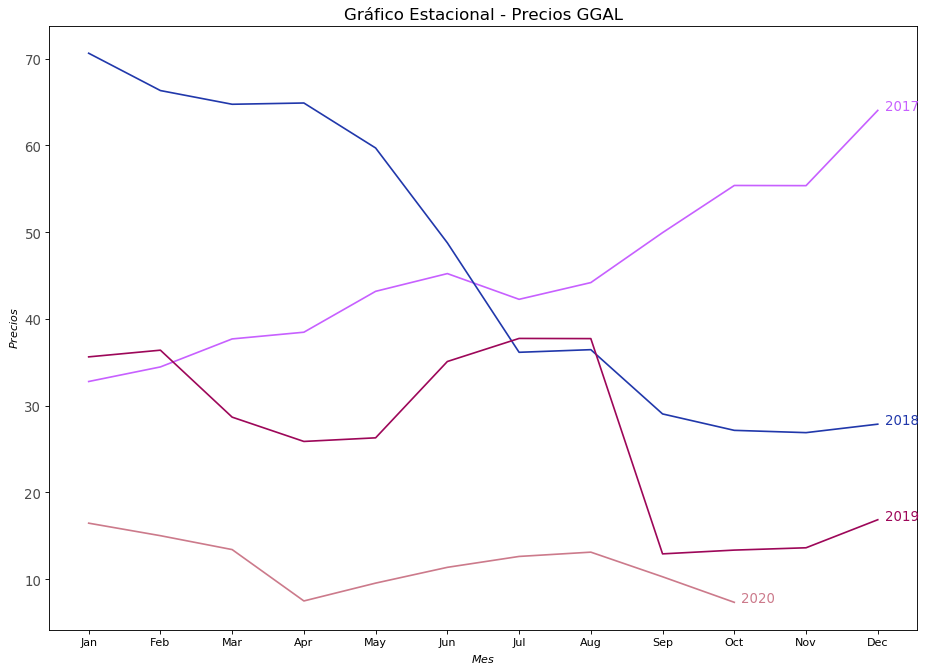

In [16]:
# Preparamos los colores:
np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)

# Ploteamos
plt.figure(figsize=(14,10), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Adj Close', data=ggal_last.loc[ggal_last.year==y, :], color=mycolors[i], label=y) # grafica los 12 meses de cada año
        plt.text(ggal_last.loc[ggal_last.year==y, :].shape[0]-.9, ggal_last.loc[ggal_last.year==y, 'Adj Close'][-1:].values[0], y, fontsize=12, color=mycolors[i])


plt.gca().set(ylabel='$Precios$', xlabel='$Mes$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Gráfico Estacional - Precios GGAL", fontsize=15);

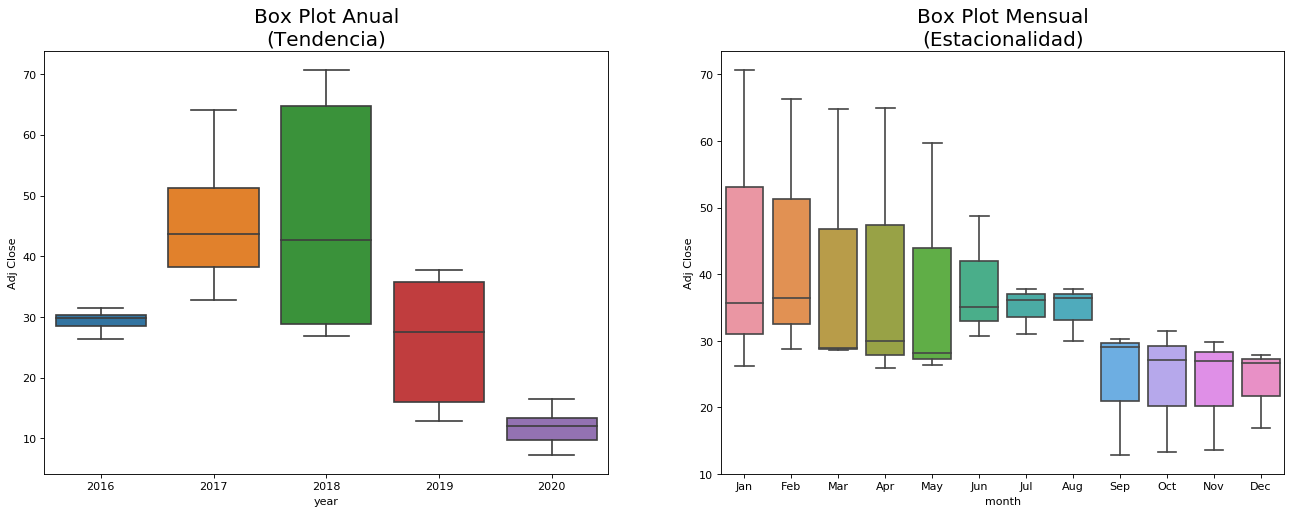

In [17]:
# Definimos los plots:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='Adj Close', data=ggal_last, ax=axes[0])
sns.boxplot(x='month', y='Adj Close', data=ggal_last.loc[~ggal_last.year.isin([2017, 2020]), :])

# Seteamos los títulos:
axes[0].set_title('Box Plot Anual\n(Tendencia)', fontsize=18); 
axes[1].set_title('Box Plot Mensual\n(Estacionalidad)', fontsize=18);

## Modelos

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
ggal_5y["timeIndex"] = pd.Series(np.arange(len(ggal_5y['Adj Close'])), index=ggal_5y.index)

In [20]:
ggal_5y = ggal_5y.join(pd.get_dummies(ggal_5y['month'], drop_first=True), how='left')

In [21]:
ggal_5y

,Adj Close,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,
2016-01-04,25.234743,2016,Jan,0,0,0,0,1,0,0,0,0,0,0,0
2016-01-05,25.148024,2016,Jan,1,0,0,0,1,0,0,0,0,0,0,0
2016-01-06,24.646992,2016,Jan,2,0,0,0,1,0,0,0,0,0,0,0
2016-01-07,24.396471,2016,Jan,3,0,0,0,1,0,0,0,0,0,0,0
2016-01-08,23.827993,2016,Jan,4,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-14,6.610000,2020,Oct,1204,0,0,0,0,0,0,0,0,0,1,0
2020-10-15,6.560000,2020,Oct,1205,0,0,0,0,0,0,0,0,0,1,0
2020-10-16,6.760000,2020,Oct,1206,0,0,0,0,0,0,0,0,0,1,0


In [22]:
# Días registrados en el último año
len(ggal_5y.loc[ggal_5y.index.year==2020,:])

203

In [23]:
ggal_train, ggal_test = train_test_split(ggal_5y, test_size=len(ggal_5y.loc[ggal_5y.index.year==2020,:]), random_state=42, shuffle=False)

In [24]:
ggal_train.tail(3)

,Adj Close,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,
2019-12-27,16.234283,2019,Dec,1003,0,1,0,0,0,0,0,0,0,0,0
2019-12-30,16.105755,2019,Dec,1004,0,1,0,0,0,0,0,0,0,0,0
2019-12-31,16.046432,2019,Dec,1005,0,1,0,0,0,0,0,0,0,0,0


In [25]:
ggal_test.head(3)

,Adj Close,year,month,timeIndex,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
Date,,,,,,,,,,,,,,,
2020-01-02,16.224398,2020,Jan,1006,0,0,0,1,0,0,0,0,0,0,0
2020-01-03,15.621297,2020,Jan,1007,0,0,0,1,0,0,0,0,0,0,0
2020-01-06,15.789374,2020,Jan,1008,0,0,0,1,0,0,0,0,0,0,0


### Tendencia con transformación logarítmica

In [26]:
import statsmodels.formula.api as smf

In [48]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [49]:
# transformación logarítmica de la curva de precios
ggal_train['log_value'] = np.log(ggal_train.loc[:,'Adj Close'])
ggal_test['log_value'] = np.log(ggal_test.loc[:,'Adj Close'])

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


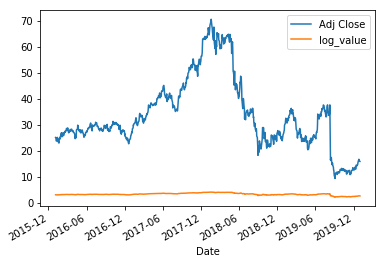

In [50]:
ggal_train.plot(kind="line", y = ['Adj Close','log_value']);

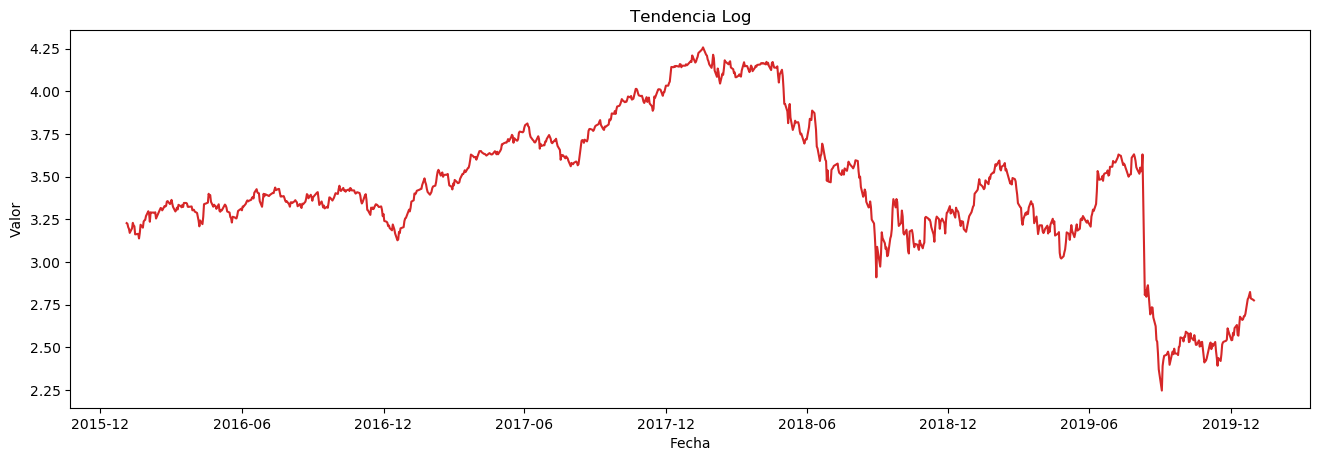

In [30]:
plot_df(ggal_train, x=ggal_train.index, y=ggal_train['log_value'], title='Tendencia Log')

In [31]:
model_log = smf.ols('log_value ~ timeIndex ', data = ggal_train).fit()

No presenta una tendencia marcada.

In [32]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     102.7
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           4.86e-23
Time:                        15:16:45   Log-Likelihood:                -490.52
No. Observations:                1006   AIC:                             985.0
Df Residuals:                    1004   BIC:                             994.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6580      0.025    147.191      0.000       3.609       3.707
timeIndex     -0.0004   4.28e-05    -10.133      0.000      -0.001      -0.000
==============================================================================
Omnibus:                       18.455   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               12.062
Skew:                           0.126   Prob(JB):                      0.00240
Kurtosis:                       2.526   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
ggal_train['model_log'] = model_log.predict(ggal_train[["timeIndex"]])
ggal_test['model_log'] = model_log.predict(ggal_test[["timeIndex"]])

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# back-transformation de la predicción
ggal_train['back_model_log'] = np.exp(ggal_train['model_log'])
ggal_test['back_model_log'] = np.exp(ggal_test['model_log'])

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


#### Train -  transformación logarítmica

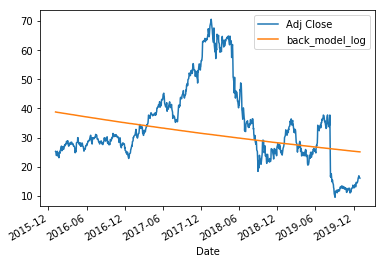

In [35]:
ggal_train.plot(kind = "line", y = ['Adj Close', 'back_model_log']);

In [36]:
RMSE(ggal_train['back_model_log'], ggal_train['Adj Close'])

13.807040793323685

#### Test - transformación logarítmica

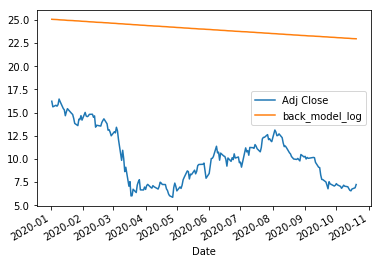

In [37]:
ggal_test.plot(kind = "line", y = ['Adj Close', 'back_model_log']);

In [38]:
RMSE(ggal_test['back_model_log'], ggal_test['Adj Close'])

14.04071130602098

### Tendencia con transformación logarítmica y estacionalidad
El R2 disminuye incluso teniendo en cuenta la estacionalidad.

In [39]:
model_log_est = smf.ols('log_value ~ timeIndex + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep',\
                          data = ggal_train).fit()

In [40]:
model_log_est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_value   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     17.89
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           2.97e-35
Time:                        15:17:26   Log-Likelihood:                -441.03
No. Observations:                1006   AIC:                             908.1
Df Residuals:                     993   BIC:                             971.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7185      0.046     81.085      0.000       3.628       3.808
timeIndex     -0.0003   4.23e-05     -8.228      0.000      -0.000      -0.000
Aug           -0.1917      0.058     -3.328      0.001      -0.305      -0.079
Dec           -0.1959      0.060     -3.289      0.001      -0.313      -0.079
Feb            0.0248      0.060      0.414      0.679      -0.093       0.142
Jan           -0.0025      0.059     -0.042      0.967      -0.119       0.114
Jul            0.0086      0.059      0.147      0.883      -0.107       0.124
Jun            0.0077      0.058      0.131      0.896      -0.107       0.122
Mar           -0.0098      0.058     -0.169      0.866      -0.124       0.104
May           -0.0417      0.058     -0.718      0.473      -0.156       0.072
Nov           -0.2458      0.059     -4.160      0.000      -0.362      -0.130
Oct           -0.2651      0.058     -4.564      0.000      -0.379      -0.151
Sep           -0.3184      0.059     -5.353      0.000      -0.435      -0.202
==============================================================================
Omnibus:                       44.670   Durbin-Watson:                   0.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.124
Skew:                           0.332   Prob(JB):                     1.06e-07
Kurtosis:                       2.429   Cond. No.                     7.30e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.3e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
ggal_train['model_log_est'] = model_log_est.predict(ggal_train[["timeIndex", "Aug", "Dec", "Feb", "Jan", "Jul", "Jun", "Mar", "May","Nov", "Oct", "Sep"]])
ggal_train['back_model_log_est'] = np.exp(ggal_train['model_log_est'])

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Train - transformación logarítmica y estacionalidad

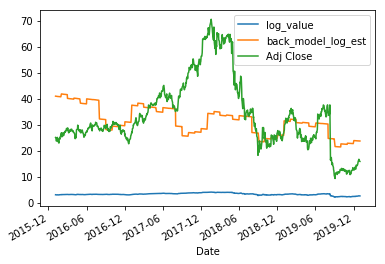

In [51]:
ggal_train.plot(kind = "line", y = ['log_value', 'back_model_log_est', 'Adj Close']);

#### Test - transformación logarítmica y estacionalidad

In [45]:
ggal_test['model_log_est'] = model_log_est.predict(ggal_test[["timeIndex", \
                                              "Aug", "Dec", "Feb", "Jan",\
                                               "Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
ggal_test['back_model_log_est'] = np.exp(ggal_test['model_log_est'])

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


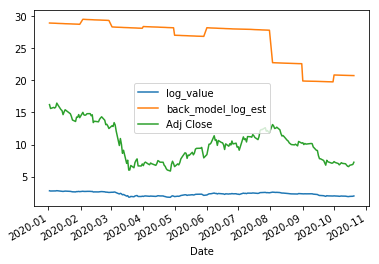

In [52]:
ggal_test.plot(kind = "line", y = ['log_value', 'back_model_log_est','Adj Close']);

### Ciclos y Series Estacionarias

#### Residuos

In [93]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt


In [65]:
decompose = seasonal_decompose(ggal_5y['Adj Close'], period=12)

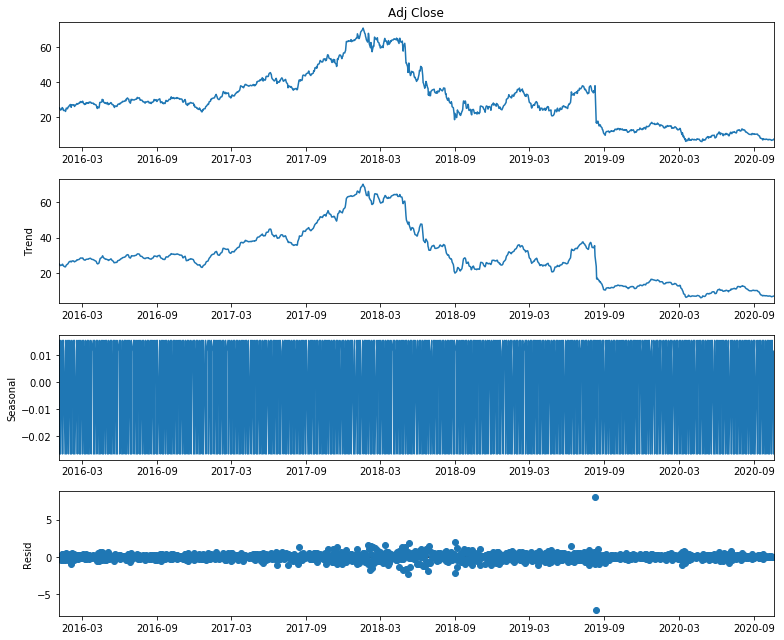

In [98]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposition = seasonal_decompose(ggal_5y['Adj Close'], period=3)
fig = decomposition.plot()
plt.show()

In [99]:
from statsmodels.tsa.stattools import adfuller

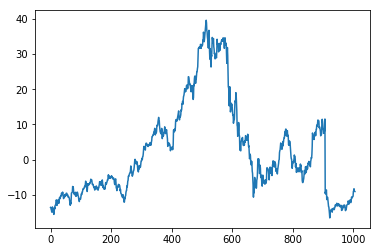

In [55]:
res_model_log = ggal_train['Adj Close'] - ggal_train['back_model_log']
plt.plot(ggal_train.timeIndex, res_model_log, '-');

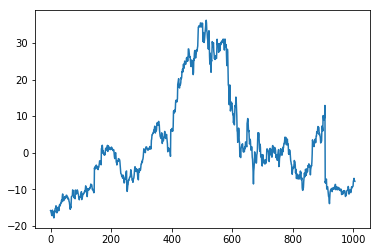

In [54]:
res_model_log_est = ggal_train['Adj Close'] - ggal_train['back_model_log_est']
plt.plot(ggal_train.timeIndex, res_model_log_est, '-');

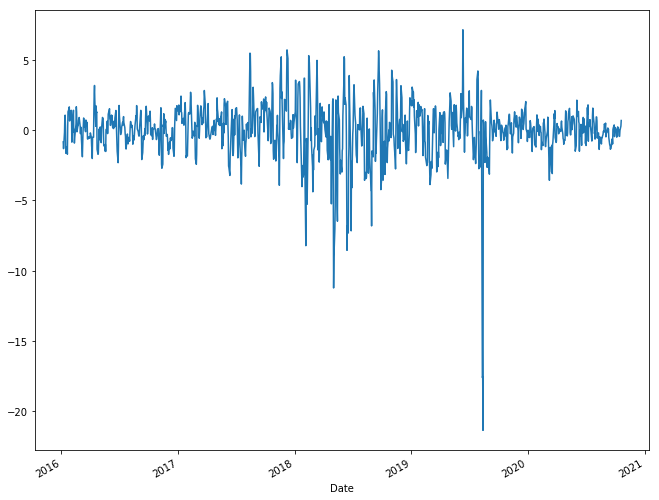

In [100]:
ggal_5y['Adj Close'].diff(3).dropna().plot()

In [94]:
lag_acf = acf(res_model_log, nlags = 20)
lag_pacf = pacf(res_model_log_est, nlags=20, method='ols');

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


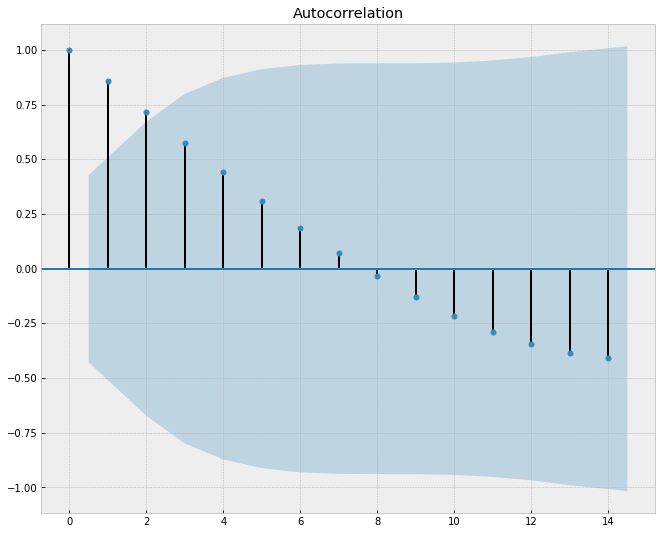

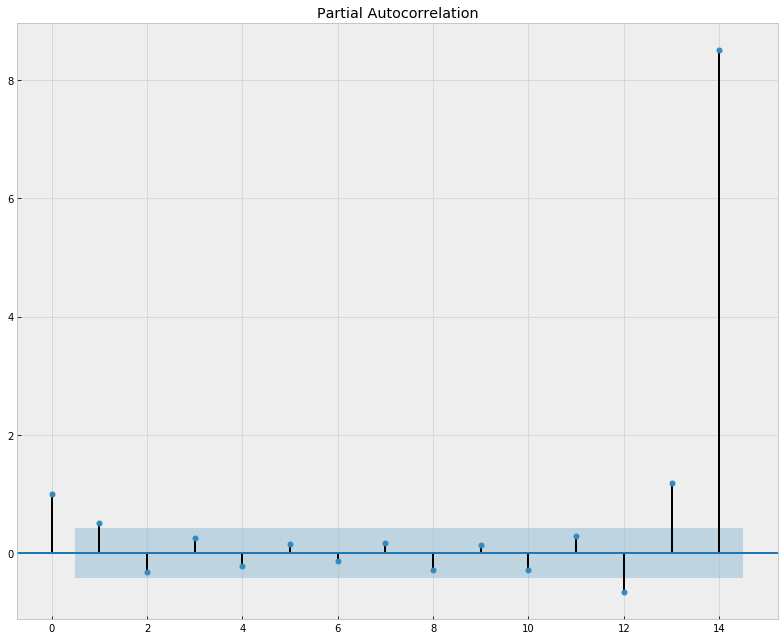

In [97]:
with plt.style.context('bmh'):
    smt.graphics.plot_acf(lag_acf)
    smt.graphics.plot_pacf(lag_pacf)
    plt.tight_layout()

In [102]:
result = adfuller(res_model_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

ADF Statistic: -1.725549
p-value: 0.417999
Valor crítico 1%: -3.44
Valor crítico 5%: -2.86
Valor crítico 10%: -2.57


In [103]:
from statsmodels.tsa.arima_model import ARIMA

In [105]:
model_ARIMA = ARIMA(res_model_log, order=(3,0,3))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Date
2016-01-04     2.940325
2016-01-05   -13.473133
2016-01-06   -13.542553
2016-01-07   -14.037178
2016-01-08   -14.244444
dtype: float64

In [106]:
print(results_ARIMA.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1006
Model:                     ARMA(3, 3)   Log Likelihood               -1625.227
Method:                       css-mle   S.D. of innovations              1.214
Date:                Tue, 20 Oct 2020   AIC                           3266.454
Time:                        16:39:11   BIC                           3305.764
Sample:                             0   HQIC                          3281.390
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9403      2.820      1.043      0.297      -2.587       8.468
ar.L1.y        1.2283        nan        nan        nan         nan         nan
ar.L2.y        0.5348        nan        nan        n

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


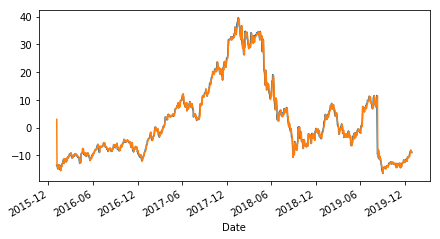

In [108]:
plt.figure(figsize=(7,3.5))
res_model_log.plot()
results_ARIMA.fittedvalues.plot();

/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/guido/anaconda3/envs/dh/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


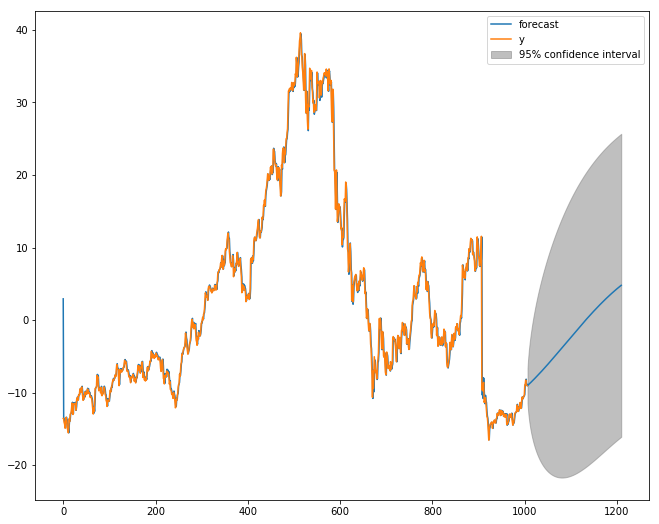

In [110]:
results_ARIMA.plot_predict(end=len(ggal_5y['Adj Close']));